# Figure S17

In [7]:
import numpy as np
import tifffile as tiff
import matplotlib.pyplot as plt
from skimage.draw import disk
from scipy.optimize import curve_fit
import seaborn as sns
import pandas as pd
# ==== Load TIFF ====
tif_path = "FigureS17.tif" # Replace with your file
stack = tiff.imread(tif_path)
bleach_frame = 21
time_per_frame = 0.13  # seconds

# ==== FIJI-style ROI coordinates (T-Z-Y-X) → (Y, X) ====
roi_data = {
    "bleach": (106, 186),
    "reference": (60, 146),
    "background": (224, 49)
}

# ==== ROI Radii ====
pixel_size_um = 0.0723621 # adjust this if you know your real value

radius_bleach = 2/pixel_size_um
radius_reference = 15
radius_background = 20

# ==== Generate Time Vector ====
times = np.arange(stack.shape[0]) * time_per_frame

# ==== Create ROI Masks ====
rr_bleach, cc_bleach = disk(roi_data["bleach"], radius_bleach)
rr_ref, cc_ref = disk(roi_data["reference"], radius_reference)
rr_bg, cc_bg = disk(roi_data["background"], radius_background)

# ==== Extract Intensities ====
I_raw = np.array([np.mean(f[rr_bleach, cc_bleach]) for f in stack])
I_fading = np.array([np.mean(f[rr_ref, cc_ref]) for f in stack])
I_bg = np.array([np.mean(f[rr_bg, cc_bg]) for f in stack])

# ==== Apply Eq. 1: Correction ====
I_corrected = (I_raw - I_bg) / (I_fading - I_bg)

# ==== Apply Eq. 2: Normalize by prebleach ====
I_prebleach = np.mean(I_corrected[:bleach_frame])
I_normalized = I_corrected / I_prebleach

# ==== Eq. 3: Exponential fit ====
def exp_recovery(t, A, tau, C):
    return A * (1 - np.exp(-t / tau)) + C

fit_t = times[bleach_frame:]
fit_y = I_normalized[bleach_frame:]
params, _ = curve_fit(exp_recovery, fit_t, fit_y, bounds=([0, 0, 0], [2, 200, 1]))
A, tau, C = params
half_time = tau * np.log(2)
mobile_fraction = A

# ==== Eq. 4: Diffusion constant ====
r_um = radius_bleach * pixel_size_um

D = 0.224 * (r_um ** 2) / half_time



In [8]:
colors = [  "#56B4E9", "#009E73", "#CC79A7", "#999999", "#E69F00","#DB2B39", "#0076A1", "#0072B2", "#1A5042","#0C1713", "#6A6969"]
palette = sns.color_palette(colors)
n = 1

sns.set_theme(context='notebook', style='ticks', font='Arial', 
              font_scale=1.3, 
              rc={"lines.linewidth": n, 'axes.linewidth':n, 
                                  "xtick.major.width":n,"ytick.major.width":n}, 
              palette = palette)
sns.color_palette(colors)

[(0.33725490196078434, 0.7058823529411765, 0.9137254901960784),
 (0.0, 0.6196078431372549, 0.45098039215686275),
 (0.8, 0.4745098039215686, 0.6549019607843137),
 (0.6, 0.6, 0.6),
 (0.9019607843137255, 0.6235294117647059, 0.0),
 (0.8588235294117647, 0.16862745098039217, 0.2235294117647059),
 (0.0, 0.4627450980392157, 0.6313725490196078),
 (0.0, 0.4470588235294118, 0.6980392156862745),
 (0.10196078431372549, 0.3137254901960784, 0.25882352941176473),
 (0.047058823529411764, 0.09019607843137255, 0.07450980392156863),
 (0.41568627450980394, 0.4117647058823529, 0.4117647058823529)]

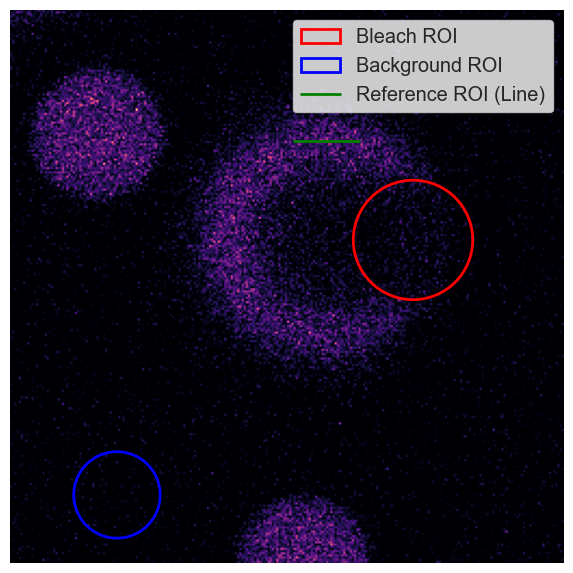

In [9]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle

# Frame image (should be defined from your TIFF stack)
frame = stack[bleach_frame]

# === ROI info from previous code ===
bleach_center = roi_data["bleach"]
ref_center = roi_data["reference"]
bg_center = roi_data["background"]

radius_bg = radius_background
ref_line_half_width = radius_reference

# Compute line start and end from center
ref_line_y = ref_center[0]
ref_line_x_start = ref_center[1] - ref_line_half_width
ref_line_x_end = ref_center[1] + ref_line_half_width

# === Plot ===
fig, ax = plt.subplots(figsize=(6, 6))
ax.imshow(frame, cmap="magma")

# Bleach ROI (circle)
circle_bleach = Circle(bleach_center[::-1], radius_bleach, edgecolor='red', facecolor='none', linewidth=2, label="Bleach ROI")
ax.add_patch(circle_bleach)

# Background ROI (circle)
circle_bg = Circle(bg_center[::-1], radius_bg, edgecolor='blue', facecolor='none', linewidth=2, label="Background ROI")
ax.add_patch(circle_bg)

# Reference ROI (line)
ax.plot([ref_line_x_start, ref_line_x_end], [ref_line_y, ref_line_y], color='green', linewidth=2, label="Reference ROI (Line)")

# Final touches
ax.legend(loc="upper right")
ax.axis("off")
plt.tight_layout()
plt.show()


Mobile fraction: 0.980
Half-time (t½): 7.25 s
Diffusion constant D: 0.1237 µm²/s


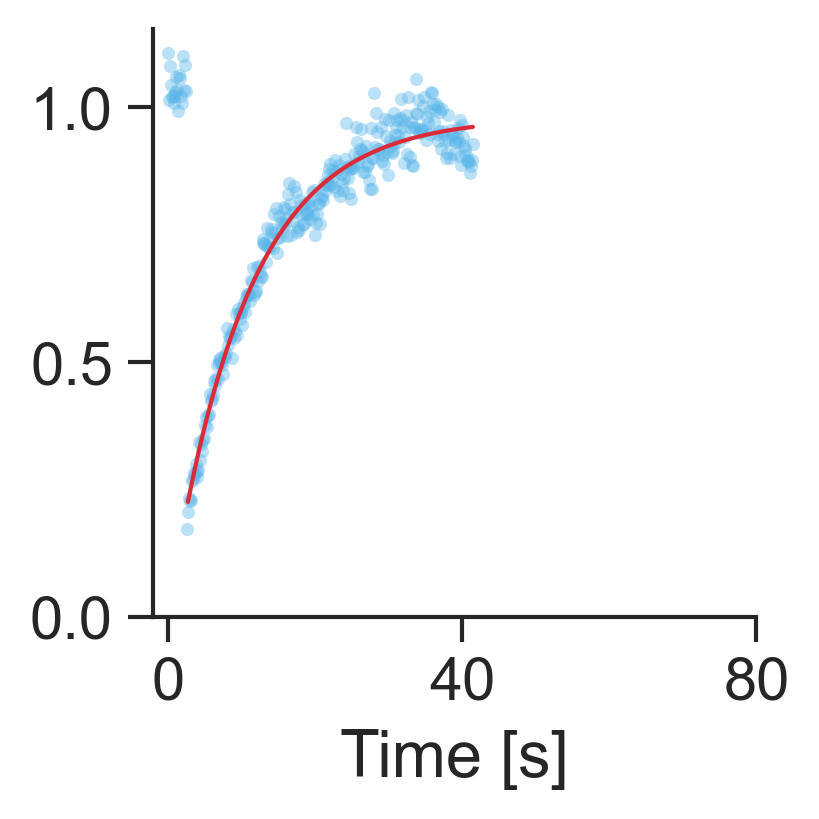

In [10]:
# ==== Plot ====
fig, axs = plt.subplots(figsize=(3, 3), dpi = 300)
plt.scatter(times, I_normalized, label='Corrected & Normalized', alpha = 0.4, lw = 0, s = 10)
#plt.axvline(times[bleach_frame], color='C5', linestyle='--', label='Bleach')
plt.plot(times[bleach_frame:], exp_recovery(times[bleach_frame:], *params), ls = "-", label='Fit', lw = 1, color = "C5")
plt.xlabel("Time [s]")
plt.ylabel("")
sns.despine(fig, top = True, right = True)
plt.tight_layout()
axs.set(xticks=np.linspace(0, 80, 3), yticks=np.linspace(0, 1, 3))

# ==== Output ====
print(f"Mobile fraction: {mobile_fraction:.3f}")
print(f"Half-time (t½): {half_time:.2f} s")
print(f"Diffusion constant D: {D:.4f} µm²/s")

In [11]:
df_params = pd.DataFrame({
    "Parameter": ["A (Mobile Fraction)", "Tau (s)", "Offset C", "Half-time t1/2 (s)", "Diffusion D (µm²/s)"],
    "Value": [params[0], params[1], params[2], half_time, D]
})
df_params

,Parameter,Value
0,A (Mobile Fraction),9.797688e-01
1,Tau (s),1.045303e+01
2,Offset C,4.122980e-20
3,Half-time t1/2 (s),7.245486e+00
4,Diffusion D (µm²/s),1.236632e-01
